# Maximum Independent Set
Quantum Optimization Benchmark Library: https://doi.org/10.48550/arXiv.2504.03832

s. also here: https://github.com/eggerdj/independent_set_benchmarking/blob/main/notebooks/independent_set_kangaroo.ipynb


Hardware: Apple M1 Pro (8 cores, 16 GB memory)

## Notes

Binary linear program:
$$
    \max _{x \in\{0,1\}^n} \sum_{i \in V} x_i \text { subject to } x_i+x_j \leq 1 \text { for all }(i, j) \in E.
$$

Binary quadratic program:
$$
    \max _{x \in\{0,1\}^n} \sum_{i \in V} x_i \text { subject to } x_i x_j=0 \text { for all }(i, j) \in E.
$$

Binary to Ising:
$$
    x_i = \frac 12 (1 - z_i).
$$

Transformation of cost function:
$$
    \max _{x \in\{0,1\}^n}\sum_{i \in V} x_i = \max _{z \in\{-1,1\}^n} \left(\mathrm{const.} -\frac 12 \sum_{i \in V} z_i \right).
$$

Transformation of constraint:
$$
    x_i x_j = 0 \iff \frac 14 (1 - z_i - z_j + z_i z_j) = 0 . 
$$

## Benchmark

In [2]:
using Quicopt, LinearAlgebra
using CPUTime
using Printf, Crayons
using PythonPlot
Base.show(io::IO, f::Float64) = @printf(io, "%1.5f", f)

In [3]:
function load_dimacs_graph_matrix(filepath::String)
    num_nodes = 0
    adj_matrix = falses(0, 0) # Initialize as an empty BitMatrix

    open(filepath, "r") do file_stream
        for line in eachline(file_stream)
            parts = split(line)
            isempty(parts) && continue # Skip empty or whitespace-only lines
            # println(parts)

            token = parts[1]
            if token == "p" && length(parts) >= 3 && parts[2] == "edge"
                num_nodes = parse(Int, parts[3])
                adj_matrix = falses(num_nodes, num_nodes)
            elseif token == "e" && length(parts) >= 3 && num_nodes > 0
                u = parse(Int, parts[2])
                v = parse(Int, parts[3])
                # Assuming 1-based indexing and valid u,v as per DIMACS
                adj_matrix[u, v] = true
                adj_matrix[v, u] = true # Undirected graph
            end
            # Comment lines (starting with 'c') or other lines are implicitly ignored.
        end
    end
    
    return adj_matrix
end

load_dimacs_graph_matrix (generic function with 1 method)

In [4]:
PATH = "../../instances/max_independent_set/"
filename = "mammalia-kangaroo-interactions.gph";

In [5]:
# load graph from file
graph = load_dimacs_graph_matrix(PATH * filename)

# system size
N = size(graph)[1]

# Lagrange multiplier
λ = 1.05

# cost function
local_fields = -ones(N) + 0.5λ .* (ones(N)' * graph)';
couplings = -0.5λ .* graph

tensor_problem = TensorProblem(local_fields, couplings);

In [6]:
# solver parameters
T = 50.0;

In [8]:
# run to force precompilation
mf_sol = solve(tensor_problem, T)
sol_vec = sign.(mf_sol.u[end][3, :]);

In [9]:
# get CPU time
@CPUtime begin
    mf_sol = solve(tensor_problem, T)
    sol_vec = sign.(mf_sol.u[end][3, :])
end;

elapsed CPU time: 0.00505 seconds


In [10]:
# energy
E = 0.5 .* (sol_vec' * couplings * sol_vec) + local_fields' * sol_vec |> println

38.77500


In [11]:
# map from Ising to binary
bit_string = (1 .- sol_vec) ./ 2

# check violated clauses
bit_string' * graph * bit_string |> println

# check max. indep. set
sum(bit_string) |> println

0.00000
4.00000


In [12]:
bit_string .|> Int |> println

[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Exact solutions

In [13]:
all_energies = []
all_bstrings = []
N = length(local_fields)
for i = 0:2^N-1
    str = bitstring(i)
    vec = [1 - 2 * parse(Int, s_i) for s_i in str[end-N+1:end]] 
    push!(all_bstrings, str)
    push!(all_energies, local_fields' * vec + 0.5 * (vec' * couplings * vec))
end
E_max = maximum(all_energies)
E_max |> println

38.77500


In [14]:
all_max_idxs = findall(E -> isapprox(E, E_max, atol=1e-13), all_energies) 
for idx in all_max_idxs
    max_bs = [parse(Int, s_i) for s_i in all_bstrings[idx][end-N+1:end]]
    if max_bs == Int.(bit_string)
        print(crayon"green")
    end
    print("Violated clauses: ", max_bs' * graph * max_bs, "\t")
    print("Max. indep. set: ", max_bs |> sum, "\t")
    println("Bitstring: ", max_bs)
    print(crayon"black")
end

Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Violated clauses: 0	Max. indep. set: 4	Bitstring: [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0

## Plot trajectories

In [15]:
times = range(0, T, 513)
plot_data_nz = reduce(hcat, [mf_sol(t)[3, 1:min(N, 20)] for t in times]);

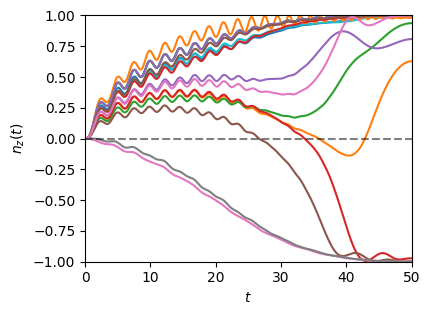

In [16]:
figure(figsize=(4, 3))
for k in 1:size(plot_data_nz)[1]
    plot(times, plot_data_nz[k, :])
end
axhline(0., color="k", alpha=0.5, ls="--")
tight_layout()
xlabel("\$t\$")
ylabel("\$ n_z(t)\$")
xlim(times[1], times[end])
ylim(-1, 1)
display(gcf())
PythonPlot.close();